In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd 
import dataretrieval.nwis as nwis
from datetime import date, timedelta
import pylab
from scipy import stats
from pylr2 import regress2
import pymannkendall as mk

home = "/Volumes/GoogleDrive/My Drive/Chapter2_mechanisms_forest_water_cycling"
sbr_ref_combo_diss = gpd.read_file(os.path.join(home, "Data", "Catchments", "Reference", "gages_ii","reference_keep.shp"))

In [2]:
def create_recession_df(gage, w, C):
    # gage= usgs gage id 
    # w is the streamflow precision thredhold 
    # C is a scalar that we multiply by w. C >= 1
    
    site = gage

    # Download the streamflow data
    #streamflow_df = nwis.get_record(sites=site, service = 'dv', start = '1984-01-01', end = '2021-12-31', parameterCd = '00060') # mean daily ft3/s 
    #streamflow_df = nwis.get_record(sites=site, service = 'dv', start = '1984-01-01', end = '2014-12-31', parameterCd = '00060') # mean daily ft3/s 
    streamflow_df = nwis.get_record(sites=site, service = 'dv', start = '1984-01-01', end = '2009-12-31', parameterCd = '00060') # mean daily ft3/s 

    streamflow_df.reset_index(inplace=True)
    # commented out below because we will use estimated values as well for gap-free time series 
    # also only using gages with no missing data, so no need to drop na's 
    #streamflow = streamflow_df[streamflow_df['00060_Mean_cd'] == 'A']
    #streamflow_df.dropna(subset=['00060_Mean'])
    #streamflow = streamflow.reset_index(drop=True)
    streamflow = streamflow_df[["datetime", "00060_Mean"]]
    streamflow.columns = ["Date", "originalQ"] # mean daily ft3/s 

    # Convert from ft3/s to mm/day 
    area_m2 = sbr_ref_combo_diss[sbr_ref_combo_diss['GAGE_ID'] == site].AREA.iloc[0] # m2 
    m2_to_ft2 = 10.7639
    ft_to_mm = 304.8
    s_to_day = 60*60*24
    convert= ((ft_to_mm * s_to_day) / (area_m2 * m2_to_ft2))
    streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)

   
    # calculate dQ and Q 
    streamflow['dQ'] = streamflow['originalQ'].diff()
    # Calculate Q = Qi + Qi-1 / 2 (matches dQ time steps)
    streamflow['Q'] = (streamflow['originalQ'] + (streamflow['originalQ'] + streamflow['dQ'].multiply(-1)))/2
    streamflow = streamflow.reset_index(drop=True)

    # Calculate time-scaled dQ and Q 
    dQ_ts = [np.nan]
    Q_ts = [np.nan]
    for i in range(1, streamflow.shape[0]):
        q_diff = streamflow['originalQ'].iloc[i] - streamflow['originalQ'].iloc[i-1]
        q = np.sum(streamflow['originalQ'].iloc[(i-1):(i +1)])/2
        if abs(q_diff) >= (w*C):
            dQ_ts.append(q_diff)
            Q_ts.append(q)
            continue
    
        steps = 1
        if abs(q_diff) < (w*C):
            for j in range(0, i):
                steps +=1
                q_diff_again = streamflow['originalQ'].iloc[i] - streamflow['originalQ'].iloc[i-steps]
                if abs(q_diff_again) < (w*C):
                    continue
                else: 
                    #dQ_ts.append(q_diff_again/(steps))
                    #Q_ts.append(np.sum(streamflow['originalQ'].iloc[(i-steps):(i+1)])/(steps))
                    date_i = streamflow['Date'].iloc[i]
                    date_old = streamflow['Date'].iloc[(i-steps)]
                    date_diff = date_i - date_old
                    delta = date_diff.days
                    dQ_ts.append(q_diff_again/delta)
                    Q_ts.append(np.sum(streamflow['originalQ'].iloc[(i-steps):(i+1)])/(delta))
                    break
    
    streamflow['dQ_ts'] = dQ_ts
    streamflow['Q_ts'] = Q_ts

    # calculate absolute value of change in dQ
    streamflow['dQdQ'] = streamflow['dQ_ts'].abs().diff()

    # drop non-consecutive dates because that will have an incorrect difference 
    streamflow['day_before'] = pd.concat([pd.Series([np.nan]), streamflow['Date'].iloc[0:(streamflow.shape[0]-1)].add(timedelta(days=1))]).to_list()
    streamflow = streamflow[(streamflow['Date'] == streamflow['day_before'])]
    streamflow = streamflow.drop(['day_before'], axis=1)

    # identify recession events 
    days_to_remove = ( (streamflow['dQ_ts'] >= 0) |   # removes days of non decreasing flow 
                    (streamflow['Q_ts'] <= 0) |   # remove days of 0 streamflow
                    (streamflow['dQdQ'] >= 0)  # remove days where the absolute value of the derivate is not decreasing 
                    )
    decreasing_streamflow = streamflow[-days_to_remove]   

    # Individual events must be at least 5 consecutive days 
    # Remove the first day of each event
    # loop through and increase the counter for every time there is a consevutive date and put that counter in the index for every loop 
    counting_days = []
    consecutive = 0
    for i in range(0, (decreasing_streamflow.shape[0]-1)):
        if i == 0:
            date = decreasing_streamflow['Date'].iloc[i]
            date_next = decreasing_streamflow['Date'].iloc[i+1]
            if (date+timedelta(days=1)) == date_next:
                consecutive += 1
            else: 
                consecutive = 0
            counting_days.append(consecutive)
    
        if i >0:
            date = decreasing_streamflow['Date'].iloc[i]
            date_next = decreasing_streamflow['Date'].iloc[i+1]
            date_prior = decreasing_streamflow['Date'].iloc[i-1]

            if (date+timedelta(days=1)) == date_next:
                consecutive += 1
                counting_days.append(consecutive)  
            elif ( (date+timedelta(days=1) != date_next) & (date-timedelta(days=1) == date_prior)):
                consecutive += 1
                counting_days.append(consecutive)  
                consecutive = 0
            else: 
                consecutive =0
                counting_days.append(consecutive)      

    decreasing_streamflow['consec_days'] = counting_days + [np.nan]   
    decreasing_streamflow = decreasing_streamflow.reset_index(drop=True)

    # find the events that are at least 5 days long 
    idx_gte5 = decreasing_streamflow[decreasing_streamflow['consec_days']>=5].index.tolist()
    idx_1 = decreasing_streamflow[decreasing_streamflow['consec_days']==1].index.tolist()

    K = 0
    for upper_idx in idx_gte5:
        K += 1
        met_condition = [j for j in idx_1 if j<upper_idx ]
        lower_idx = met_condition[len(met_condition)-1]
        if K == 1:
            keep_idx = list(range(lower_idx, upper_idx+1))
        else:
            keep_idx = keep_idx + list(range(lower_idx, upper_idx+1))
    
    final_idx = np.unique(keep_idx)
    recessions = decreasing_streamflow.iloc[final_idx]
    recessions = recessions.reset_index(drop=True)

    # drop the first day of each recession 
    recessions = recessions[recessions['consec_days'] != 1]

    # subset to the months of interest (june - august)
    #recessions = recessions.loc[recessions['Date'].dt.month.isin([6,7,8])]
    recessions = recessions.loc[recessions['Date'].dt.month.isin([6, 7, 8, 9])]

    # label each individual event
    event_number = []
    event_counter = 0
    for i in range(0, recessions.shape[0]):
        if i == 0:
            event_counter = 1
            event_number.append(event_counter)
        else: 
            if recessions['consec_days'].iloc[i] > recessions['consec_days'].iloc[i-1]:
                event_counter = event_counter + 0
                event_number.append(event_counter)
            else:
                event_counter = event_counter + 1
                event_number.append(event_counter)

    recessions['event_number'] = event_number

    # take the log transform of Q and dQ 
    recessions['log_dQ']=np.log10(recessions['dQ_ts'].abs()) # make sure to take the log of the absolute value of dQ
    recessions['log_Q']=np.log10(recessions['Q_ts'])
    
    return recessions



def calculate_coef(df, gage, reg_type, start_year):
    #start_year = df.Date.iloc[0].year
    if reg_type == "OLS":
        slope, intercept, r_value, p_value, std_err = stats.linregress(df.log_Q, df.log_dQ)
        b_val = slope
        medEvSlope = np.median(b_val)
        df['log_dQ_offset'] = df.log_dQ - (df.log_Q * medEvSlope)
        a_val = np.mean(df.log_dQ_offset)
        return {'Gage':gage, 'Year':start_year, 'A':a_val, 'B':b_val}
    if reg_type == "RMA":
        results = regress2(df.log_Q, df.log_dQ, _method_type_2="reduced major axis")
        b_val = results['slope']
        medEvSlope = np.median(b_val)
        df['log_dQ_offset'] = df.log_dQ - (df.log_Q * medEvSlope)
        a_val = np.mean(df.log_dQ_offset)
        return {'Gage': gage, 'Year':start_year, 'A':a_val, 'B':b_val, 'A_std':results['std_intercept'], 'B_std':results['std_slope']}



def rolling(df, gage, reg_type, interval):

    # make a list of start and end years for each interval 
    #start_year = df.Date.iloc[0].year
    start_year = 1984
    #end_year = df.Date.iloc[df.shape[0]-1].year
    end_year = 2009
    starts = range(start_year, end_year + 2 - interval)
    ends = [x + (interval-1) for x in starts]

    # loop through each interval 
    coefficients = []
    for i in range(0, len(starts)):
        start = starts[i]
        end = ends[i]
        df_sub = df.loc[df['Date'].dt.year.isin(range(start, end + 1))]
        if df_sub.shape[0] <= 4: 
            continue
        df_sub = df_sub.reset_index(drop=True)
        coefficients.append(calculate_coef(df_sub, gage, reg_type, start))
    
    return pd.DataFrame(coefficients)


In [6]:
# first subset the reference watersheds to those with no missing data 
def check_streamflow(site):
    
    # quality control 
    # A = Approved for publication 
    # P = Provisional data subject to revision 
    # e = Value has been estimated 

    streamflow_df = nwis.get_record(sites=site, service = 'dv', start = '1900-01-01', parameterCd = '00060')
    if streamflow_df.shape[0] == 0:
        return np.nan
    date_index = streamflow_df.index.to_series().between('1984-01-01', '2021-12-31')
    streamflow_subset = streamflow_df[date_index]
    #streamflow_subset = streamflow_subset[streamflow_subset['00060_Mean_cd'] == 'A']
    streamflow_subset.dropna(subset=['00060_Mean'])
    streamflow = streamflow_subset.reset_index(drop=True)
    # I want to use the estimated values because we can't have gaps 

    sdate = date(1984, 1, 1)
    edate = date(2021, 12, 31)
    delta = edate-sdate
    total_days = delta.days + 1
    
    pct_missing = (streamflow_subset.shape[0]/total_days)*100
    
    return pct_missing


pct_miss= []
for gage_id in sbr_ref_combo_diss['GAGE_ID']:
    pct_miss.append(check_streamflow(gage_id))
sbr_ref_combo_diss['pct_stream'] = pct_miss

sbr_ref_combo_diss_100 = sbr_ref_combo_diss[sbr_ref_combo_diss['pct_stream'] == 100]

/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_35370/3035366107.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_35370/3035366107.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_35370/3035366107.py:115: SettingWithCopyWarning: 
A value is trying to be set

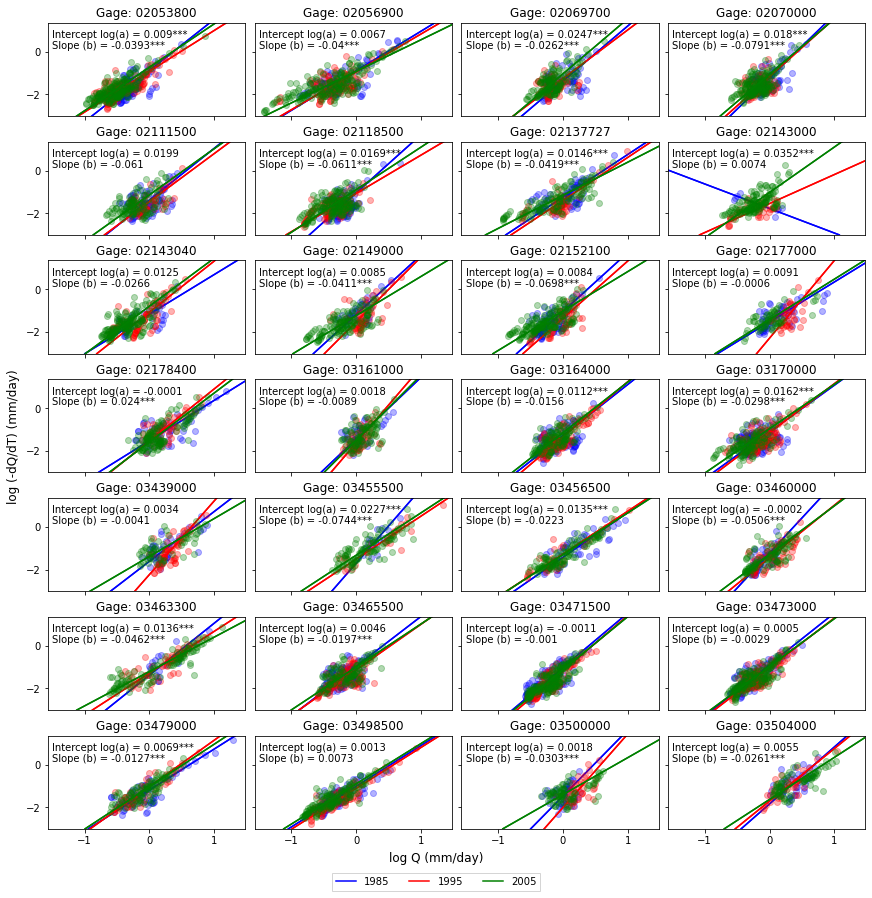

In [145]:
fig, axes = pylab.subplots(nrows=7, ncols=4, figsize=(12,12), sharex=True, sharey=True, constrained_layout=True,)

for i, ax in enumerate(axes.flatten()):
    site = sbr_ref_combo_diss_100.GAGE_ID.iloc[i]
    recessions = create_recession_df(site, w=0.01, C=3)
    coefs_3r = rolling(recessions, site, 'RMA', 5)
    coefs_3r['New_Year'] = coefs_3r['Year'] - 1984
    slope_A, intercept_A, r_value_A, p_value_A, std_err_A = stats.linregress(coefs_3r.New_Year, coefs_3r.A)
    slope_B, intercept_B, r_value_B, p_value_B, std_err_B = stats.linregress(coefs_3r.New_Year, coefs_3r.B)

    r_1985_1989 = recessions.loc[recessions['Date'].dt.year.isin(range(1985, 1989 + 1))]
    A_1985 = coefs_3r[coefs_3r['Year'] == 1985].A.iloc[0]
    B_1985 = coefs_3r[coefs_3r['Year'] == 1985].B.iloc[0]
    ax.plot(r_1985_1989['log_Q'], r_1985_1989['log_dQ'],'o', alpha=0.3, color='blue')
    ax.axline((0, A_1985), slope=B_1985, color='blue', label='by slope')
    hm1 = ax.axline((0, A_1985), slope=B_1985, color='blue', label='by slope')

    r_1995_1999 = recessions.loc[recessions['Date'].dt.year.isin(range(1995, 1999 + 1))]
    A_1995 = coefs_3r[coefs_3r['Year'] == 1995].A.iloc[0]
    B_1995 = coefs_3r[coefs_3r['Year'] == 1995].B.iloc[0]
    ax.plot(r_1995_1999['log_Q'], r_1995_1999['log_dQ'],'o', alpha=0.3, color='red')
    ax.axline((0, A_1995), slope=B_1995, color='red', label='by slope')
    hm2 = ax.axline((0, A_1995), slope=B_1995, color='red', label='by slope')

    r_2005_2009 = recessions.loc[recessions['Date'].dt.year.isin(range(2005, 2009 + 1))]
    A_2005 = coefs_3r[coefs_3r['Year'] == 2005].A.iloc[0]
    B_2005 = coefs_3r[coefs_3r['Year'] == 2005].B.iloc[0]
    ax.plot(r_2005_2009['log_Q'], r_2005_2009['log_dQ'],'o', alpha=0.3, color='green')
    ax.axline((0, A_2005), slope=B_2005, color='green', label='by slope')
    hm3= ax.axline((0, A_2005), slope=B_2005, color='green', label='by slope')

    if p_value_A > 0.05:
        A_text= 'Intercept log(a) = ' + str(round(slope_A, 4))
    elif p_value_A <= 0.05:
        A_text= 'Intercept log(a) = ' + str(round(slope_A, 4)) + "***"
    
    if p_value_B > 0.05:
        B_text= 'Slope (b) = ' + str(round(slope_B, 4))
    elif p_value_B <= 0.05:
        B_text= 'Slope (b) = ' + str(round(slope_B, 4)) + "***"
   
    ax.text(-1.5, 0.65, A_text, fontsize=10)
    ax.text(-1.5, 0.15, B_text, fontsize=10)
    
    ax.set_title('Gage: ' + site)

fig.supxlabel('log Q (mm/day)')
fig.supylabel('log (-dQ/dT) (mm/day)')
handles= [hm1, hm2, hm3]
labels = ["1985", "1995", "2005"]
fig.legend(handles,labels, bbox_to_anchor=(0.5,-0), ncol=len(labels), fancybox=False, shadow=False, loc='upper center')
#pylab.xlabel("log Q (mm/day)")
#pylab.ylabel("log (-dQ/dT) (mm/day)")

pylab.show()

/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_2773/1571719740.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_2773/1571719740.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_2773/1571719740.py:115: SettingWithCopyWarning: 
A value is trying to be set on

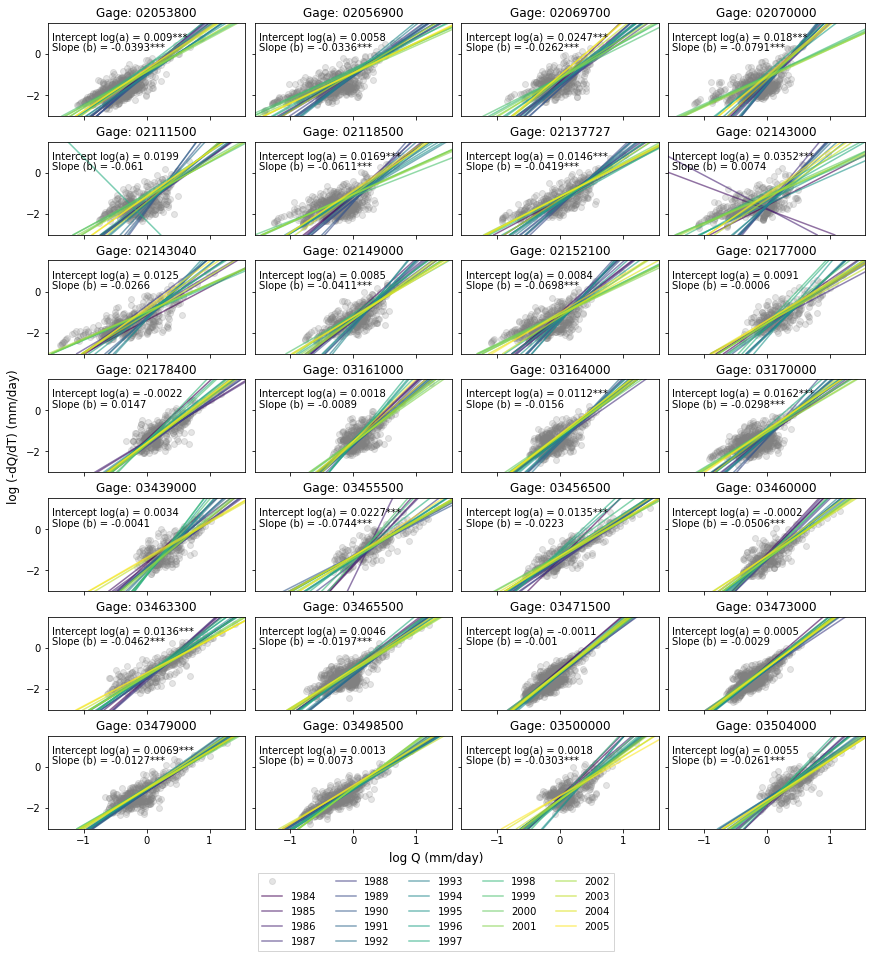

In [18]:
nrow = 7
ncol=4
#nrow = 2
#ncol=2
fig, axes = pylab.subplots(nrows=nrow, ncols=ncol, figsize=(12,12), sharex=True, sharey=True, constrained_layout=True)

n=22
colors = pylab.cm.viridis(np.linspace(0,1,22))

for i, ax in enumerate(axes.flatten()):
    site = sbr_ref_combo_diss_100.GAGE_ID.iloc[i]
    recessions = create_recession_df(site, w=0.01, C=3)
    coefs_3r = rolling(recessions, site, 'RMA', 5)
    coefs_3r['New_Year'] = coefs_3r['Year'] - 1984
    slope_A, intercept_A, r_value_A, p_value_A, std_err_A = stats.linregress(coefs_3r.New_Year, coefs_3r.A)
    slope_B, intercept_B, r_value_B, p_value_B, std_err_B = stats.linregress(coefs_3r.New_Year, coefs_3r.B)

    ax.plot(recessions['log_Q'], recessions['log_dQ'],'o', alpha=0.2, color='grey')

    for j, c in zip(range(1984, 2006), colors):
        if j not in coefs_3r.Year.tolist():
            continue
        A = coefs_3r[coefs_3r['Year'] == j].A.iloc[0]
        B = coefs_3r[coefs_3r['Year'] == j].B.iloc[0]
        ax.axline((0, A), slope=B, color= c, alpha = 0.6)

    ax.set_title('Gage: ' + site)
    if p_value_A > 0.05:
        A_text= 'Intercept log(a) = ' + str(round(slope_A, 4))
    elif p_value_A <= 0.05:
        A_text= 'Intercept log(a) = ' + str(round(slope_A, 4)) + "***"
    
    if p_value_B > 0.05:
        B_text= 'Slope (b) = ' + str(round(slope_B, 4))
    elif p_value_B <= 0.05:
        B_text= 'Slope (b) = ' + str(round(slope_B, 4)) + "***"
   
    ax.text(-1.5, 0.65, A_text, fontsize=10)
    ax.text(-1.5, 0.15, B_text, fontsize=10)

fig.supxlabel('log Q (mm/day)')
fig.supylabel('log (-dQ/dT) (mm/day)')
labels = list(range(1984, 2006, 1))
labels = [""] + [str(x) for x in labels]
fig.legend(labels, bbox_to_anchor=(0.5,-0), ncol=5, fancybox=False, shadow=False, loc='upper center')
#pylab.xlabel("log Q (mm/day)")
#pylab.ylabel("log (-dQ/dT) (mm/day)")

pylab.show()

In [56]:
from matplotlib.lines import Line2D


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_2773/1571719740.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_2773/1571719740.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_2773/1571719740.py:115: SettingWithCopyWarning: 
A value is trying to be set on

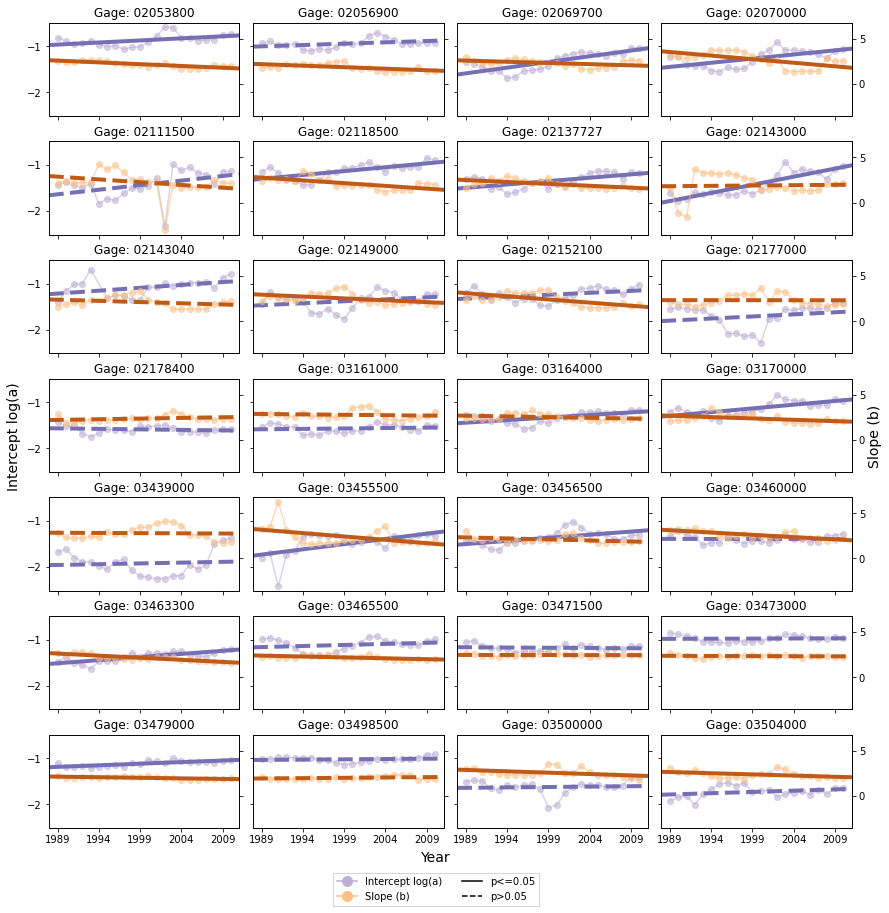

In [80]:
nrow = 7
ncol=4
#nrow = 2
#ncol=2
fig, axes = pylab.subplots(nrows=nrow, ncols=ncol, figsize=(12,12), sharex=True, sharey=True, constrained_layout=True)

ax2_list = []
ax1_list = []
for i, ax in enumerate(axes.flatten()):

    site = sbr_ref_combo_diss_100.GAGE_ID.iloc[i]
    recessions = create_recession_df(site, w=0.01, C=3)
    coefs_3r = rolling(recessions, site, 'RMA', 5)
    coefs_3r['New_Year'] = coefs_3r['Year'] - 1984
    slope_A, intercept_A, r_value_A, p_value_A, std_err_A = stats.linregress(coefs_3r.New_Year, coefs_3r.A)
    slope_B, intercept_B, r_value_B, p_value_B, std_err_B = stats.linregress(coefs_3r.New_Year, coefs_3r.B)

    ax.plot(coefs_3r['New_Year'], coefs_3r['A'],marker='o', alpha=0.55, color = "#beaed4",label="Intercept log(A)")
    # color="#7570b3",
    ax.set_xticklabels(['1984', '1989', '1994', '1999', '2004', '2009'])
    
    ax2 = ax.twinx()
    ax2.plot(coefs_3r['New_Year'], coefs_3r['B'],marker='o', alpha=0.55, color = "#fdc086", label="Slope (b)")
    # color="#bf5b17",
    
    # !!!!
    ax2_list.append(ax2)

    total = nrow * ncol 
    last_col = range(ncol, total + 1, ncol)
    last_col = [x-1 for x in last_col]    
    if i not in last_col:
        ax1_list.append(ax2)
    
    ax.set_title('Gage: ' + site)
    if p_value_A > 0.05:
        #A_text= 'Intercept log(a) = ' + str(round(slope_A, 4))
        ax.axline((0, intercept_A), slope=slope_A, color= "#7570b3", alpha = 1, linewidth=4, linestyle = '--')
    elif p_value_A <= 0.05:
        #A_text= 'Intercept log(a) = ' + str(round(slope_A, 4)) + "***"
        ax.axline((0, intercept_A), slope=slope_A, color= "#7570b3", alpha = 1, linewidth=4)
    
    if p_value_B > 0.05:
        #B_text= 'Slope (b) = ' + str(round(slope_B, 4))
        ax2.axline((0, intercept_B), slope=slope_B, color= "#bf5b17", alpha = 1, linewidth=4, linestyle = '--')
    elif p_value_B <= 0.05:
        #B_text= 'Slope (b) = ' + str(round(slope_B, 4)) + "***"
        ax2.axline((0, intercept_B), slope=slope_B, color= "#bf5b17", alpha = 1, linewidth=4)

for sax in ax2_list:
    ax2.get_shared_y_axes().join(ax2, sax)
ax2.autoscale()
for sax in ax1_list:
    sax.yaxis.set_tick_params(labelright=False)

fig.supxlabel('Year', fontsize=14)
fig.supylabel('Intercept log(a)', fontsize=14)
fig.text(1, 0.5, 'Slope (b)', color='black', va='center', rotation='vertical', fontsize=14)

#ugh = ax.plot(coefs_3r['New_Year'], coefs_3r['A'],'o', alpha=0.55, color="#beaed4", label="Intercept log(A)")
#ugh2 = ax2.plot(coefs_3r['New_Year'], coefs_3r['B'],'o', alpha=0.55, color="#fdc086", label="Slope (b)")
#handles = ugh + ugh2
#labels = ["Intercept log(a)", "Slope (b)"]
line_solid = Line2D([0], [0], label='p<=0.05', color='black')
line_dash = Line2D([0], [0], label='p>0.05', color='black', linestyle="--")
purple_dot = Line2D([], [], color="#beaed4", marker='o', markersize=10, label='Intercept log(a)')
orange_dot = Line2D([], [], color="#fdc086", marker='o', markersize=10, label='Slope (b)')
handles = [purple_dot, orange_dot, line_solid, line_dash]
#handles.extend([line_solid, line_dash])
fig.legend(handles=handles,bbox_to_anchor=(0.5,-0), ncol=2, fancybox=False, shadow=False, loc='upper center')


pylab.show()

In [12]:
# make a dt of annual a and b coefficients for each variable 
K = -1
for i in sbr_ref_combo_diss_100.GAGE_ID:
    K += 1
    site = i
    recessions = create_recession_df(site, w=0.01, C=3)
    coefs_3r = rolling(recessions, site, 'RMA', 5)
    coefs_3r['New_Year'] = coefs_3r['Year'] - 1984

    if K == 0: 
        rsc = coefs_3r
    else:
        rsc = pd.concat([rsc, coefs_3r])


/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_32792/1571719740.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['originalQ'] = streamflow['originalQ'].multiply(convert)
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_32792/1571719740.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamflow['dQ'] = streamflow['originalQ'].diff()
/var/folders/6_/17bx0qz13sjdf13yymjj7kb00000gn/T/ipykernel_32792/1571719740.py:115: SettingWithCopyWarning: 
A value is trying to be set

In [15]:
rsc.to_csv(os.path.join(home, "Data", "Streamflow", "rolling_recession_coefficients.csv"), index=False)